# Sensitivity analysis and parameter space visualization

This notebook performs general sensitivity analysis (GSA) as well as OFAT on the forest model and visualizes the parameter space covered by this data. The last section looks at the distribution of tree volume spatially.

To generate data for a desired parameter space, run the first cell in section 1.

#### Contents:
1. General Sensitivity Analysis
2. 2D and 3D Parameter Space Sweeps
3. OFAT on $N_H$, $P_H$ and $\gamma$
4. Tree volume distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import pyarrow as pa
import pyarrow.parquet as pq
import random

from scipy.fftpack import fft2, fftshift
from scipy.ndimage import label, sum_labels

import model as mdl
import visualisation as vis
import sensitivity_analysis as sa

import warnings
warnings.filterwarnings("ignore")

## 1. General Sensitivity Analysis

In [ ]:
"""
Generate GSA data for 5 parameters within given bounds.
"""

# Parameters to vary and number and bounds for the varying range
problem = {
    'num_vars': 5,
    'names': ['harvest_volume', 'harvest_nbrs', 'harvest_prob', 'fert_comp_ratio_exponent', 'top_n_sites_percent'],
    'bounds': [[50, 300],
               [0, 8],
               [0, 1],
               [-1, 1],
               [0, 1]]
}
# Output variables to collect
outputs = ["Trees", "Fungi", "Living Trees Total Volume", "Harvested volume", "Infected Trees", "Mean Substrate", "Mean Soil Fertility"]

# Random seed (CHANGE WHEN RUNNING A DIFFERENT BATCH!)
seed = 42

data = sa.run_batches(mdl.Forest, problem , outputs=outputs, n_max_timesteps=1000, n_replicates=20, n_distinct_samples=64, seed=seed)

In [5]:
# Write parquet file
table = pa.Table.from_pandas(data)
pq.write_table(table, f'sa_results_seed_{seed}.parquet')

In [37]:
# read and show data
table_read = pq.read_table(f'sa_results_all.parquet')
data_read = table_read.to_pandas()
data_read

,RunId,Step,harvest_volume,harvest_nbrs,harvest_prob,fert_comp_ratio_exponent,top_n_sites_percent,Trees,Fungi,Living Trees Total Volume,Infected Trees,Mean Substrate,Mean Soil Fertility,Harvested volume,SimId
0,0,0,55.859375,3,0.820312,0.671875,0.648438,100,50,13751.000000,0,1.0100,0.487769,0.000000,0
1,0,1,55.859375,3,0.820312,0.671875,0.648438,80,34,10569.759921,0,0.9500,0.177334,3312.968217,0
2,0,2,55.859375,3,0.820312,0.671875,0.648438,80,45,10649.989006,11,0.9275,0.143895,0.000000,0
3,0,3,55.859375,3,0.820312,0.671875,0.648438,80,27,10720.647941,11,0.9025,0.140196,0.000000,0
4,0,4,55.859375,3,0.820312,0.671875,0.648438,339,21,11048.021320,11,0.8975,0.125871,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23063035,29,996,133.984375,1,0.070312,-0.171875,0.539062,400,0,4292.504569,36,0.0150,0.067852,0.000000,23039
23063036,29,997,133.984375,1,0.070312,-0.171875,0.539062,397,38,4338.369712,36,0.0250,0.064197,0.000000,23039
23063037,29,998,133.984375,1,0.070312,-0.171875,0.539062,394,9,4166.230177,36,0.0275,0.082564,154.716754,23039
23063038,29,999,133.984375,1,0.070312,-0.171875,0.539062,392,5,4232.784974,36,0.0325,0.077087,0.000000,23039


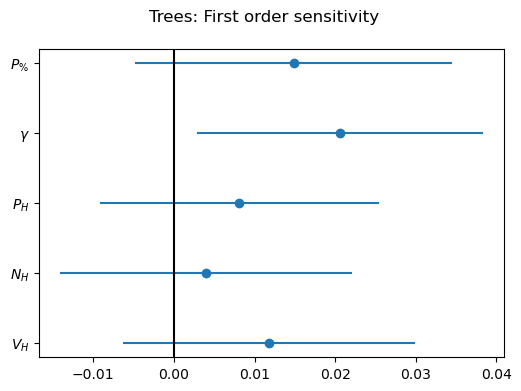

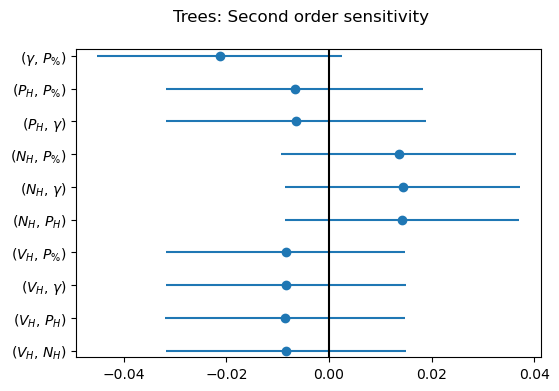

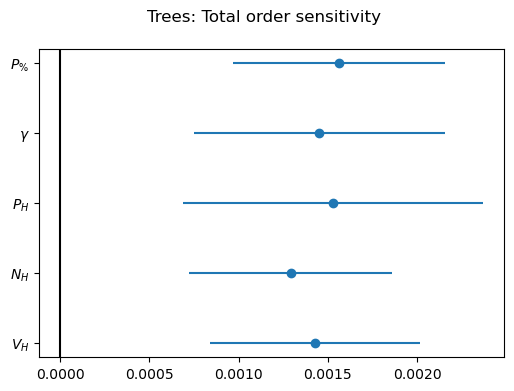

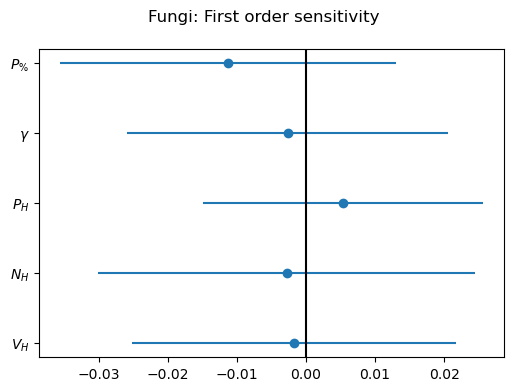

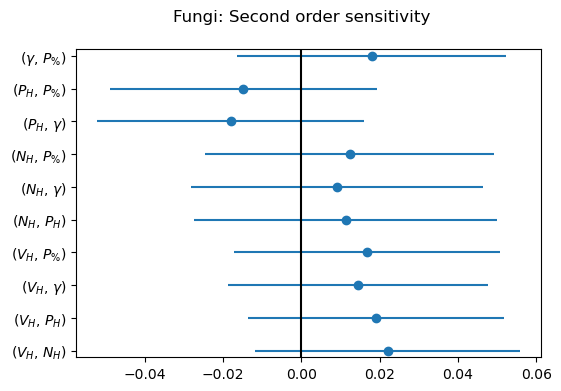

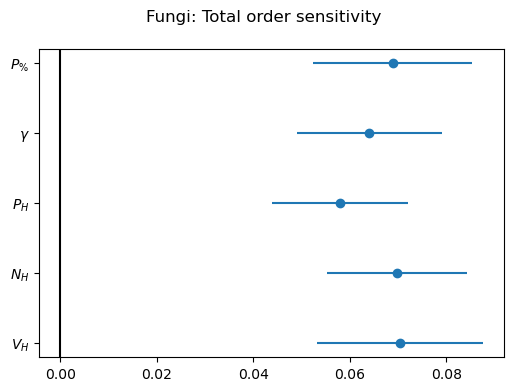

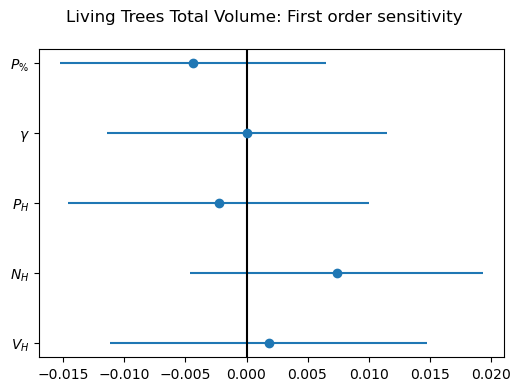

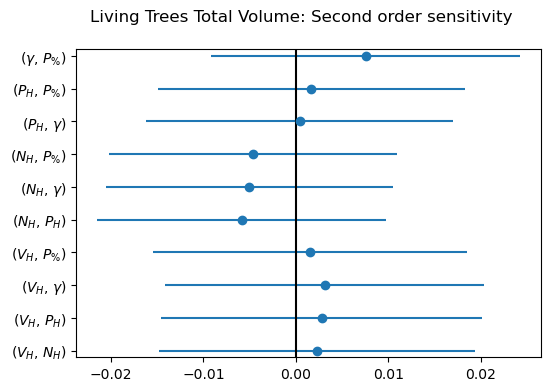

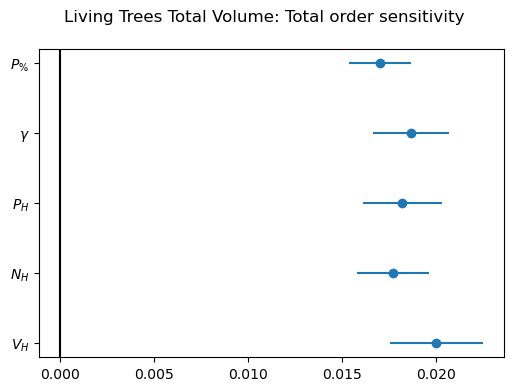

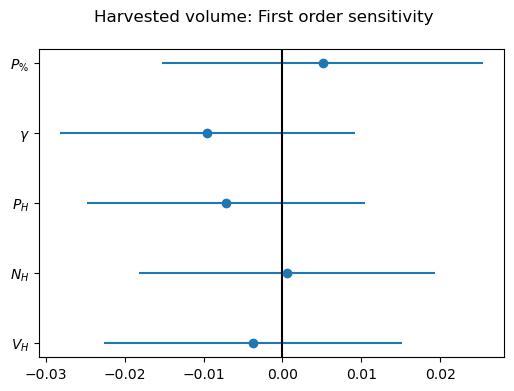

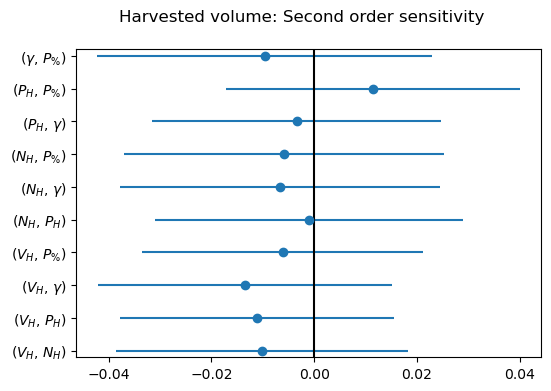

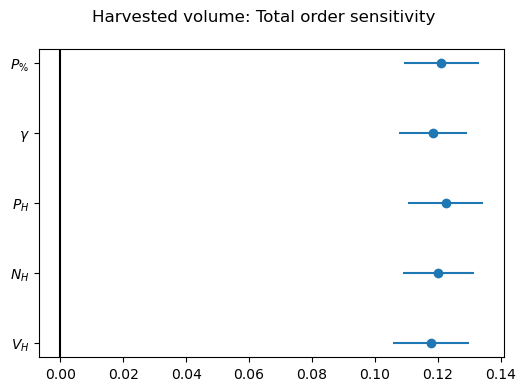

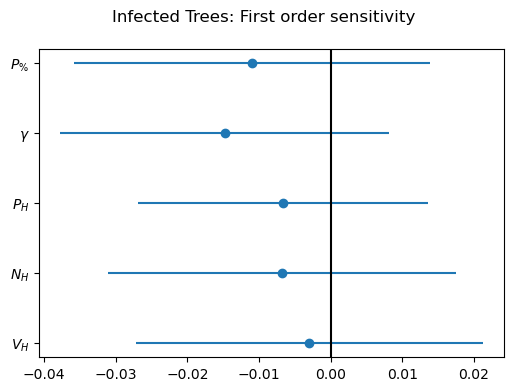

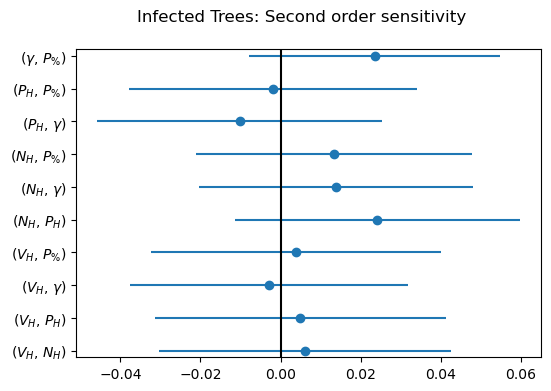

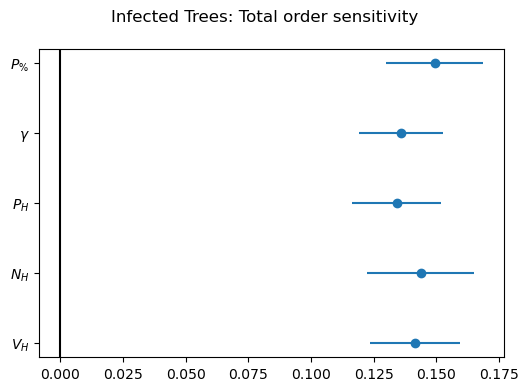

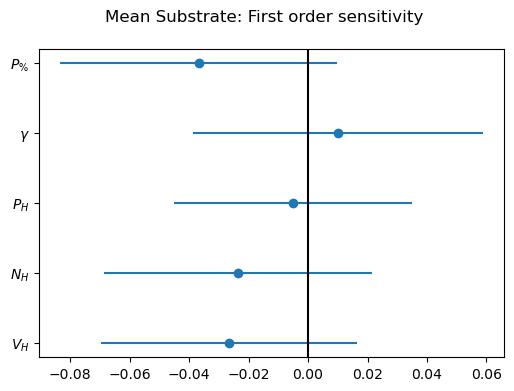

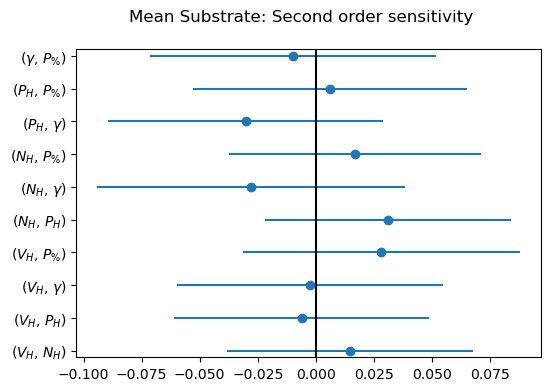

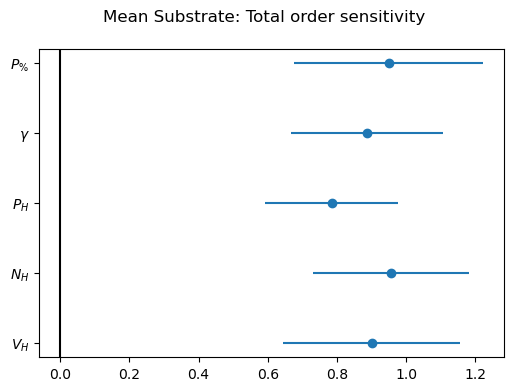

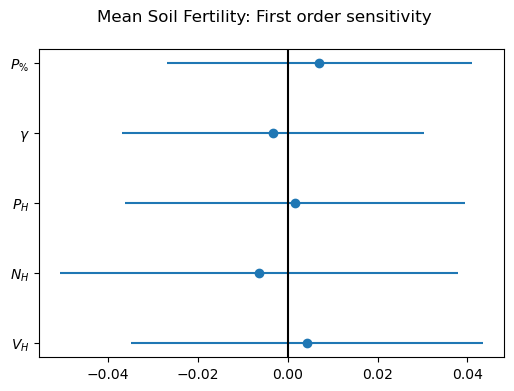

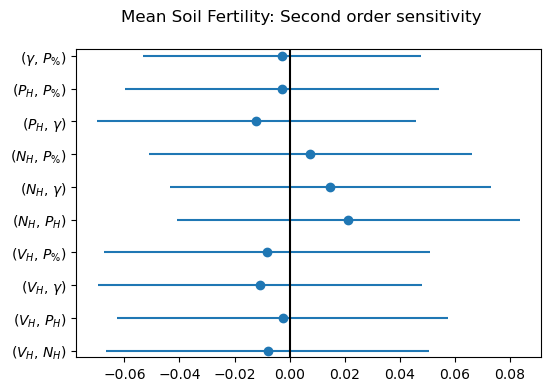

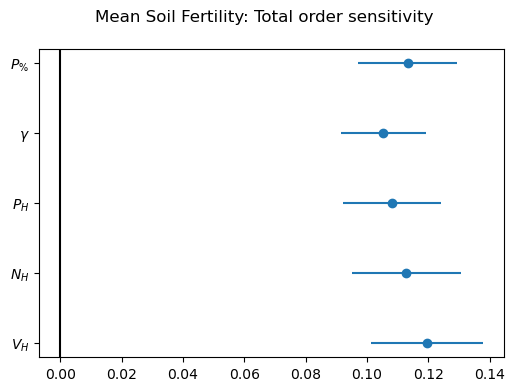

In [69]:
%matplotlib inline

si = sa.sobol_analyse(data_read, problem, outputs, mean_over_last=100)

vis.plot_index(si, problem['names'])

## 2. 2D and 3D parameter space sweeps

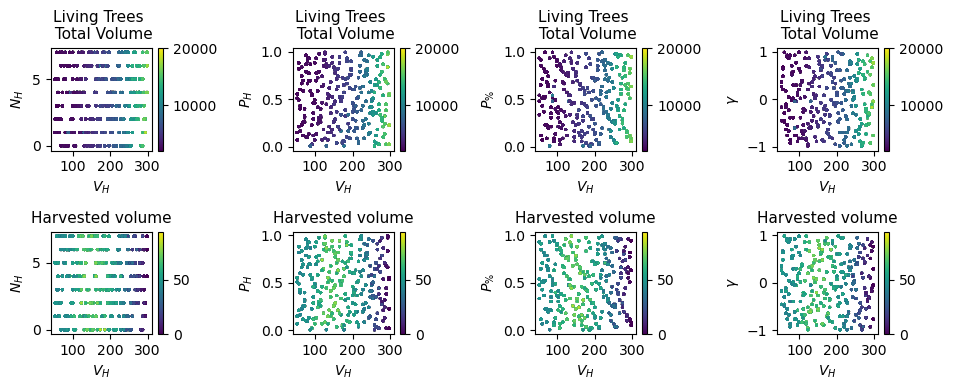

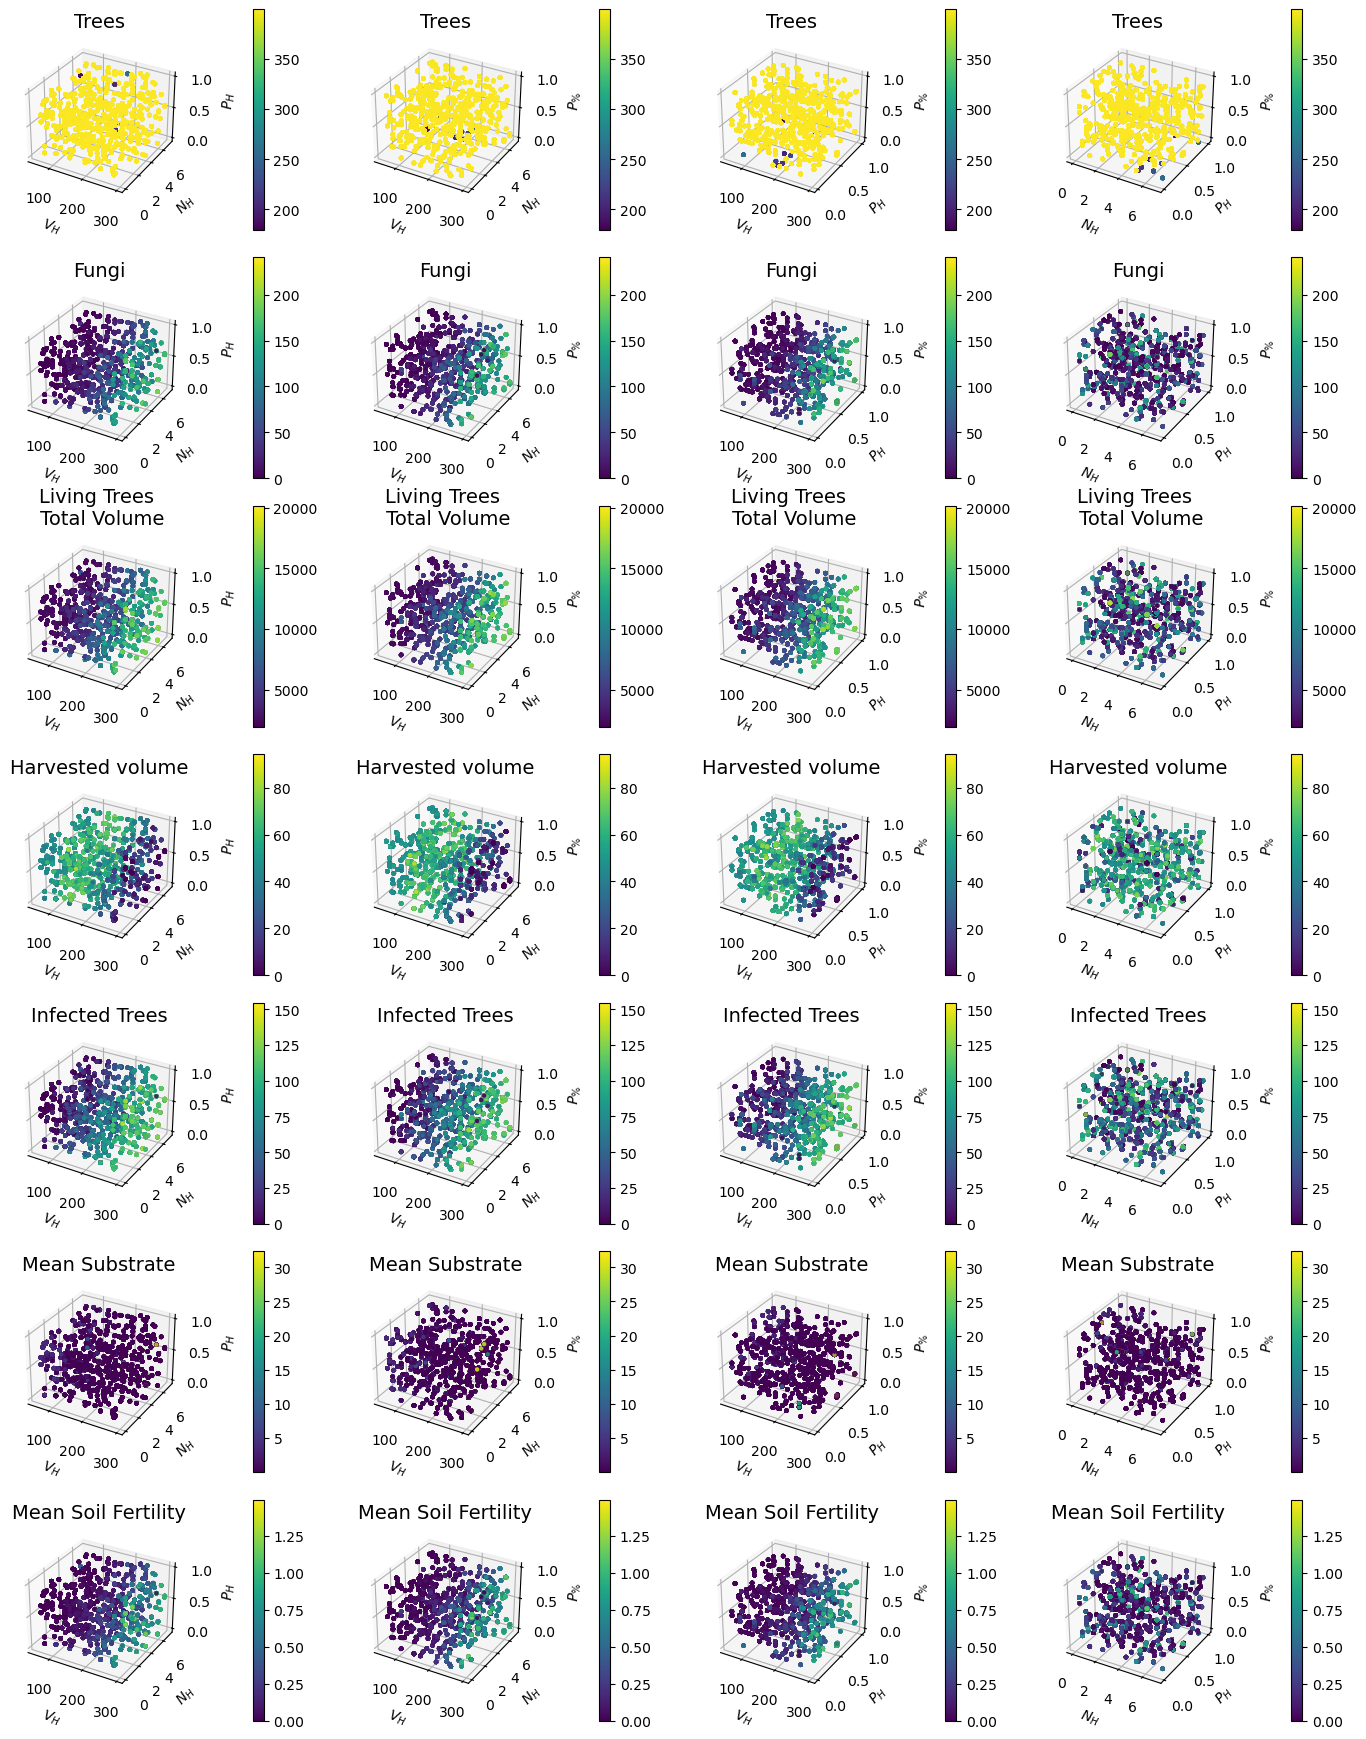

In [38]:
%matplotlib inline
# 2D parameter space plots for V_H against all other parameters
vis.plot_param_space_array_2D(data_read,
                           ['harvest_volume', 'harvest_nbrs', 'harvest_prob', 'top_n_sites_percent', 'fert_comp_ratio_exponent'],
                           outputs=["Living Trees Total Volume", "Harvested volume"], show_first=4)

# 3D plots of all parameter combinations
vis.plot_param_space_array_3D(data_read,
                           ['harvest_volume', 'harvest_nbrs', 'harvest_prob', 'top_n_sites_percent'],
                           outputs)

## 3. OFAT on $N_H$, $P_H$ and $\gamma$

In [87]:
"""
Generate OFAT data for 3 parameters within given bounds.
"""

# Parameters to vary and number and bounds for the varying range
problem = {
    'num_vars': 5,
    'names': ['harvest_nbrs', 'harvest_prob', 'fert_comp_ratio_exponent'],
    'bounds': [[0, 8],
               [0, 1],
               [-1, 1]]
}

# Default parameter values for model initialization
defaults = {
    'harvest_volume': 170,
    'harvest_nbrs': 4,
    'harvest_prob': 0.5,
    'top_n_sites_percent': 0.01,
    'fert_comp_ratio_exponent': 0.5
}

# Output variables to collect
outputs = ["Trees", "Fungi", "Living Trees Total Volume", "Harvested volume", "Infected Trees", "Mean Substrate", "Mean Soil Fertility"]

# Random seed (CHANGE WHEN RUNNING A DIFFERENT BATCH!)
seed = 66

data = sa.run_ofat_batches(mdl.Forest, problem, defaults, outputs=outputs, n_max_timesteps=1000, n_replicates=20, n_distinct_samples=16, seed=seed)

# Write parquet file
table = pa.Table.from_pandas(data)
pq.write_table(table, f'ofat_results_seed_{seed}.parquet')

64.58% done


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
data

,RunId,Step,harvest_volume,harvest_nbrs,harvest_prob,top_n_sites_percent,fert_comp_ratio_exponent,Trees,Fungi,Living Trees Total Volume,Infected Trees,Mean Substrate,Mean Soil Fertility,Harvested volume,SimId
0,0,0,170,0.0,0.5,0.01,0.5,100,50,13156.000000,0,1.4600,0.493934,0.000000,0
1,0,1,170,0.0,0.5,0.01,0.5,82,43,9437.808338,0,1.3625,0.173246,3843.529351,1
2,0,2,170,0.0,0.5,0.01,0.5,74,49,7830.000494,5,1.3250,0.146365,1697.286814,2
3,0,3,170,0.0,0.5,0.01,0.5,70,34,7018.861445,5,1.3125,0.136873,894.321717,3
4,0,4,170,0.0,0.5,0.01,0.5,73,26,6860.231220,5,1.3050,0.129070,244.698636,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,1,96,170,4.0,0.5,0.01,1.0,134,3,8756.072666,35,0.0600,0.698679,0.000000,201
1208,1,97,170,4.0,0.5,0.01,1.0,132,122,8332.399551,37,0.1200,0.693640,246.825346,202
1209,1,98,170,4.0,0.5,0.01,1.0,131,30,8189.050662,36,0.0525,0.744815,190.704752,203
1210,1,99,170,4.0,0.5,0.01,1.0,131,26,8234.435637,36,0.0475,0.739673,0.000000,204


## 4. Tree Volume Distribution

This section runs the forest model and plots the distribution of tree volume of n simulations as a histogram as well as spatially. Additionally, cluster sizes are calculated and plotted in a histogram.

In [19]:
%matplotlib inline

# Initial parameter settings
width = 20
height = 20
n_init_trees = 100
n_init_fungi = 50
fert_comp_ratio_exponent = 0.5
top_n_sites_percent_values = [0.005, 0.01, 0.02]
harvest_volume_values = [50, 170, 250]
max_substrate=3
max_soil_fertility=1
n_runs = 2

# set seed for random number generators
seed = 13
np.random.seed(seed)
random.seed(seed)

# Initialize the model and run it for each combination of parameters
fig, axes = plt.subplots(9, 3, figsize=(8, 15))#, sharex=True, sharey=True)

for i, top_n_sites_percent in enumerate(top_n_sites_percent_values):
    for j, harvest_volume in enumerate(harvest_volume_values):
        
        # Update the harvest parameters
        harvest_params = [harvest_volume, 4, 0.5]

        aggregated_volumes = np.zeros((n_runs, width * height * 100))
        aggregated_vol_diffs = np.zeros((n_runs, ((width - 1) * height + width * (height - 1)) * 100))
        aggregated_spectra = np.zeros((n_runs, width, height))
        last_volumes = np.zeros((n_runs, width, height))
        
        cluster_sizes = []

        for n in range(n_runs):

            print(f"Run {n+1} of {n_runs} for $V_H$: {harvest_volume}, $P_\%$: {top_n_sites_percent * 100}%")
            
            # Create and run the model
            model = mdl.Forest(width, height, n_init_trees, n_init_fungi, harvest_params, fert_comp_ratio_exponent, 
                            max_substrate, max_soil_fertility, top_n_sites_percent)        
            model.run_model(n_steps=1000)
            
            # Collect the data
            volumes = model.grid_volume_tracker[-100:]
            aggregated_volumes[n] = volumes.flatten()
            last_volumes[n] = volumes[-1]

            # Determine cluster sizes of volumes larger than the mean
            mean_volumes = np.mean(volumes, axis=(1,2))
            large_vol_tags = np.where(volumes > 50, 1, 0)
            
            for tags in large_vol_tags:
                volume_labels, num_features = label(tags)
                volume_labels_large = np.unique(volume_labels[tags])
                cluster_sizes.extend(sum_labels(volume_labels, volume_labels, index=volume_labels_large))

            # Perform 2D FFT on the volume data
            vol_fft = fft2(volumes)
            mag_spectrum = np.abs(fftshift(vol_fft, axes=(1, 2)))
            mag_spectrum = np.where(mag_spectrum > 5000, 5000, mag_spectrum)
            aggregated_spectra[n] = np.mean(mag_spectrum, axis=0)
            
            vol_diffs_h = np.abs(volumes[:, :, 1:] - volumes[:, :, :-1])
            vol_diffs_v = np.abs(volumes[:, 1:, :] - volumes[:, :-1, :])
            vol_diffs = np.concatenate((vol_diffs_h.flatten(), vol_diffs_v.flatten()), axis=0)
            aggregated_vol_diffs[n] = vol_diffs

        # Plot a histogram of the aggregated volumes
        ax = axes[j*3, i]
        aggregated_volumes = aggregated_volumes.flatten()
        aggregated_volumes = aggregated_volumes[aggregated_volumes != 0]
        ax.hist(aggregated_volumes, bins=20, density=True)
        ax.set_title(f'$V_H$: {harvest_volume}, $P_\%$: {top_n_sites_percent * 100}%')
        ax.set_xlabel('Tree Volume Distribution')
        ax.set_yscale('log')
        ax.set(xlim=(0, 300), ylim=(0.00001, 1))
        ax.grid(True)

        # Plot a histogram of the above average volume cluster sizes
        ax = axes[j*3+1, i]
        ax.hist(cluster_sizes, bins=20, density=True, color='lightblue')
        ax.set_xlabel('Cluster Size')
        ax.set(xlim=(0, 50), ylim=(0, 0.5))
        ax.grid(True)

        # Plot sample of tree volumes
        ax = axes[j*3+2, i]
        img = ax.imshow(last_volumes[-1], cmap='plasma')
        ax.set_title("Tree Volumes Sample\nat $t=1000$", fontsize=11)
        fig.colorbar(img, ax=ax)


plt.tight_layout()
plt.show()

Run 1 of 2 for $V_H$: 50, $P_\%$: 0.5%
Run 2 of 2 for $V_H$: 50, $P_\%$: 0.5%
Run 1 of 2 for $V_H$: 170, $P_\%$: 0.5%
Run 2 of 2 for $V_H$: 170, $P_\%$: 0.5%
Run 1 of 2 for $V_H$: 250, $P_\%$: 0.5%
Run 2 of 2 for $V_H$: 250, $P_\%$: 0.5%
Run 1 of 2 for $V_H$: 50, $P_\%$: 1.0%
Run 2 of 2 for $V_H$: 50, $P_\%$: 1.0%
Run 1 of 2 for $V_H$: 170, $P_\%$: 1.0%
Run 2 of 2 for $V_H$: 170, $P_\%$: 1.0%
Run 1 of 2 for $V_H$: 250, $P_\%$: 1.0%
Run 2 of 2 for $V_H$: 250, $P_\%$: 1.0%
